<a href="https://colab.research.google.com/github/Zeitgeisth/ML-GlassDataset/blob/main/MachineLearning_Glass_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **REQUIREMENT R1**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.manifold import TSNE
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

Loading Data from https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data

In [ ]:
columns = ['RI','Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba','Fe','Type']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data',
                 names=columns,header=None)

# a) Checking for missing values and imputing missing values if appropriate.

No null values are seen, so there's no need to impute.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


Value Count of Labels:

In [ ]:
df['Type'].value_counts()

,count
Type,
2,76
1,70
7,29
3,17
5,13
6,9


Segregating input and output fields

In [ ]:
X = df.drop('Type',axis=1)
y = df['Type']

# b) Normalizing all feature values to lie in the range 0 to 1.

Normalizing input in the range from 0 to 1

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# c) Using Kernel functions to transform data to reduce the amount of overlap between classes (particularly between classes 1 and 2).

In [ ]:

gamma = 1 / (X_scaled.shape[1] * X_scaled.var().mean())

X_rbf = rbf_kernel(X_scaled, gamma=gamma)

# d) Using the tsne visualization package to visualize the class distribution both before and after the application of the Kernel functions.

Visualization before the application of rbf kernel.



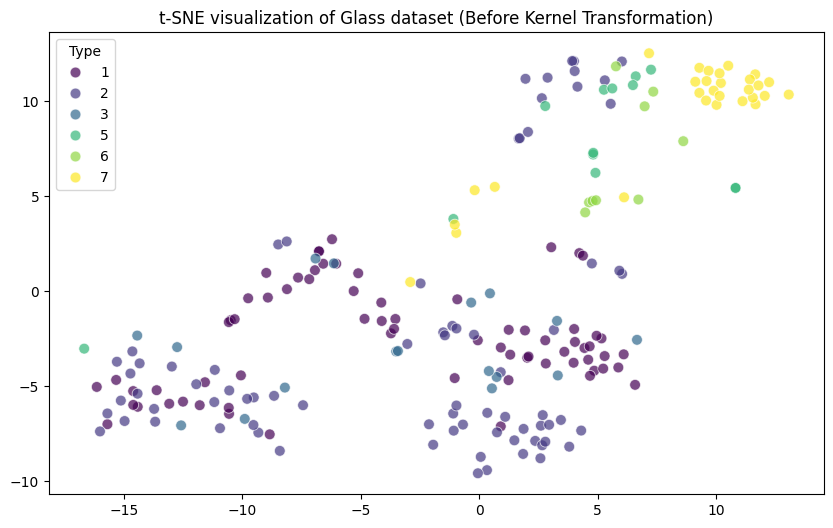

In [ ]:

tsne_before = TSNE(n_components=2, random_state=42)
X_tsne = tsne_before.fit_transform(X_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE visualization of Glass dataset (Before Kernel Transformation)")
plt.show()


Visualization after the application of rbf kernel.


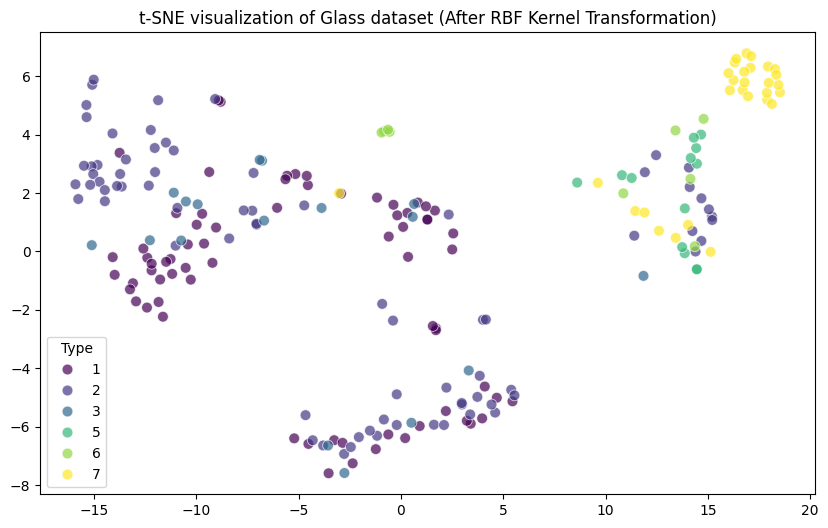

In [ ]:
tsne_after = TSNE(n_components=2, random_state=42)
X_rbf_tsne = tsne_after.fit_transform(X_rbf)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_rbf_tsne[:, 0], y=X_rbf_tsne[:, 1], hue=y, palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE visualization of Glass dataset (After RBF Kernel Transformation)")
plt.show()

# Conclusion

The RBF kernel transformation has proven to be an effective tool for enhancing the separability of classes in the Glass dataset, particularly for classes 1 and 2. By introducing non-linearity into the data, the RBF kernel allowed for a more accurate representation of the underlying relationships between the features and class labels. This resulted in a significant reduction in the overlap between the target classes, making them more distinguishable in the t-SNE visualization.

RBF Kernel maps linear non separable input data into high dimensional non-linear form so that, it can be separable by a hyperplane, so there is reduction in overlap of classes.

# **REQUIREMENT R2**

Initializing for cross validation


In [ ]:
num_folds = 10
num_repeats = 3
rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats)

# a) Generate a Linear Perceptron model both on the pre-processed data before and after the application of the Kernel function. Tune the max_iter parameter to obtain best results.


Generic function for Model Selection to perform GridSearchCV and evaluate models

In [ ]:
def tune_and_evaluate(model, param_grid, X_data, y, model_name):
    gridSearch = GridSearchCV(estimator=model, param_grid=param_grid, cv=rkf, scoring='accuracy', n_jobs=-1)
    gridSearch.fit(X_data, y)
    bestModel = gridSearch.best_estimator_

    scores = cross_validate(bestModel, X_data, y, cv=rkf, scoring=['accuracy', 'f1_macro'], return_train_score=False, n_jobs=-1)

    accuracy = np.mean(scores['test_accuracy'])
    f1 = np.mean(scores['test_f1_macro'])

    print(f"\nBest parameters for {model_name}: {gridSearch.best_params_}")
    print(f"Mean Accuracy: {accuracy:.4f}")
    print(f"Mean F1 Score (Macro): {f1:.4f}")

    return bestModel, accuracy, f1


Linear Perceptron Analysis

In [ ]:
print("Evaluating Linear Perceptron...")
perceptron = Perceptron()
perceptron_param_grid = {
                        'max_iter': [10000, 9000, 5000, 12000, 15000],
                        'tol': [0.0001, 0.0005],
                        'n_iter_no_change': [3,5,7,1],
                        'random_state': [0, 1, 42]
                         }
# without rbf
best_perceptron, accuracy_perceptron, f1_perceptron = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_scaled, y, "Linear Perceptron on Raw Data"
)

#with rbf
best_perceptron_rbf, accuracy_perceptron_rbf, f1_perceptron_rbf = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_rbf, y, "Linear Perceptron with RBF Kernel"
)

print(f"\n Best Parameter for Linear Perceptron with raw data: {best_perceptron}")
print(f"\Accuracy Perceptron for Linear Perceptron with raw data: {accuracy_perceptron}")
print(f"\F1 Perceptron for Linear Perceptron with raw data: {f1_perceptron}")

print(f"\n Best Parameter for Linear Perceptron with RBF kernel data: {best_perceptron_rbf}")
print(f"\Accuracy Perceptron for Linear Perceptron with RBF kernel data: {accuracy_perceptron_rbf}")
print(f"\F1 Perceptron for Linear Perceptron with RBF kernel data: {f1_perceptron_rbf}")

Evaluating Linear Perceptron...

Best parameters for Linear Perceptron on Raw Data: {'max_iter': 10000, 'n_iter_no_change': 7, 'random_state': 0, 'tol': 0.0005}
Mean Accuracy: 0.4052
Mean F1 Score (Macro): 0.2846

Best parameters for Linear Perceptron with RBF Kernel: {'max_iter': 10000, 'n_iter_no_change': 7, 'random_state': 42, 'tol': 0.0001}
Mean Accuracy: 0.5800
Mean F1 Score (Macro): 0.4718

 Best Parameter for Linear Perceptron with raw data: Perceptron(max_iter=10000, n_iter_no_change=7, tol=0.0005)
\Accuracy Perceptron for Linear Perceptron with raw data: 0.4051948051948051
\F1 Perceptron for Linear Perceptron with raw data: 0.28456278234632765

 Best Parameter for Linear Perceptron with RBF kernel data: Perceptron(max_iter=10000, n_iter_no_change=7, random_state=42, tol=0.0001)
\Accuracy Perceptron for Linear Perceptron with RBF kernel data: 0.5800144300144301
\F1 Perceptron for Linear Perceptron with RBF kernel data: 0.4717959124286479


**Comparison Between Perceptron using and not using Kernel**

Before using RBF Kernel, Accuracy for Linear Perceptron was 0.4491 and F1-score was 0.3377. But, after the use of Kernel Accuracy for Linear Perceptron increased to 0.5680 and F1-score increased to 0.4821.

This is because, RBF Kernel introduced the non-linearity to the data so that hyperplane could separate the class better.

Also, max_iter '1000' is good for linear perceptron as seen above.


# R1 d) Experimenting with the rbf kernel.

**Linear Perceptron Analysis using different RBF Kernel Gamma Values**

In [ ]:

gamma = 1 / (X_scaled.shape[1] * X_scaled.var().mean())

X_rbf1 = rbf_kernel(X_scaled, gamma=gamma)
X_rbf2 = rbf_kernel(X_scaled, gamma=1)
X_rbf3 = rbf_kernel(X_scaled, gamma=1/2)
X_rbf4 = rbf_kernel(X_scaled, gamma=1/10)

In [ ]:


# a) For Linear Perceptron
print("Evaluating Linear Perceptron...")
perceptron = Perceptron()
perceptron_param_grid = {
                        'max_iter': [10000],
                        'tol': [0.0001],
                        'n_iter_no_change': [5],
                        'random_state': [42]
                         }

best_perceptron_rbf1, accuracy_perceptron_rbf1, f1_perceptron_rbf1 = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_rbf1, y, "Linear Perceptron with RBF Kernel with tot_input_headers times mean variance(scaled)"
)

best_perceptron_rbf2, accuracy_perceptron_rbf2, f1_perceptron_rbf2 = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_rbf2, y, "Linear Perceptron with RBF Kernel data with gamma 1"
)

best_perceptron_rbf3, accuracy_perceptron_rbf3, f1_perceptron_rbf3 = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_rbf3, y, "Linear Perceptron with RBF Kernel data with gamma 1/2"
)

best_perceptron_rbf4, accuracy_perceptron_rbf4, f1_perceptron_rbf4 = tune_and_evaluate(
    perceptron, perceptron_param_grid, X_rbf4, y, "Linear Perceptron with RBF Kernel data with gamma 1/10"
)

print(f"\n Best Parameter for Linear Perceptron RBF kernel data with tot_input_headers times mean variance(scaled): {best_perceptron_rbf1}")
print(f"\Accuracy Perceptron for Linear Perceptron RBF kernel data with tot_input_headers times mean variance(scaled): {accuracy_perceptron_rbf1}")
print(f"\F1 Perceptron for Linear Perceptron with RBF kernel data with tot_input_headers times mean variance(scaled): {f1_perceptron_rbf1}")

print(f"\n Best Parameter for Linear Perceptron with RBF kernel data with gamma 1: {best_perceptron_rbf2}")
print(f"\Accuracy Perceptron for Linear Perceptron with RBF kernel data with gamma 1: {accuracy_perceptron_rbf2}")
print(f"\F1 Perceptron for Linear Perceptron with RBF kernel data with gamma 1: {f1_perceptron_rbf2}")

print(f"\n Best Parameter for Linear Perceptron with RBF kernel data with gamma 1/2: {best_perceptron_rbf3}")
print(f"\Accuracy Perceptron for Linear Perceptron RBF kernel data with gamma 1/2: {accuracy_perceptron_rbf3}")
print(f"\F1 Perceptron for Linear Perceptron with RBF kernel data with gamma 1/2: {f1_perceptron_rbf3}")

print(f"\n Best Parameter for Linear Perceptron with RBF kernel data with gamma 1/10: {best_perceptron_rbf4}")
print(f"\Accuracy Perceptron for Linear Perceptron with RBF kernel data with gamma 1/10: {accuracy_perceptron_rbf4}")
print(f"\F1 Perceptron for Linear Perceptron with RBF kernel data with gamma 1/10: {f1_perceptron_rbf4}")

Evaluating Linear Perceptron...

Best parameters for Linear Perceptron with RBF Kernel with tot_input_headers times mean variance(scaled): {'max_iter': 10000, 'n_iter_no_change': 5, 'random_state': 42, 'tol': 0.0001}
Mean Accuracy: 0.5770
Mean F1 Score (Macro): 0.4340

Best parameters for Linear Perceptron with RBF Kernel data with gamma 1: {'max_iter': 10000, 'n_iter_no_change': 5, 'random_state': 42, 'tol': 0.0001}
Mean Accuracy: 0.4565
Mean F1 Score (Macro): 0.3128

Best parameters for Linear Perceptron with RBF Kernel data with gamma 1/2: {'max_iter': 10000, 'n_iter_no_change': 5, 'random_state': 42, 'tol': 0.0001}
Mean Accuracy: 0.4545
Mean F1 Score (Macro): 0.2743

Best parameters for Linear Perceptron with RBF Kernel data with gamma 1/10: {'max_iter': 10000, 'n_iter_no_change': 5, 'random_state': 42, 'tol': 0.0001}
Mean Accuracy: 0.3319
Mean F1 Score (Macro): 0.1261

 Best Parameter for Linear Perceptron RBF kernel data with tot_input_headers times mean variance(scaled): Percept

While using gamma as 1, 1/2, 1/10 and 1/3.71, 1/3.71 provided better result which has accuracy of 0.59 and F1-score of 0.46.

# b) Do the same as a) above with the Logistic Regression classifier. Tune the max_iter parameter to obtain best results.


Logistic Regression Analysis

In [ ]:


print("Evaluating Logistic Regression...")
lRegression = LogisticRegression()
regression_param_grid = {
                        'max_iter': [10000, 9000, 5000, 12000, 15000],
                        'random_state': [0, 1, 42]
                         }

best_regression, accuracy_regression, f1_regression = tune_and_evaluate(
    lRegression, regression_param_grid, X_scaled, y, "Logistic Regression on Raw Data"
)

best_regression_rbf, accuracy_regression_rbf, f1_regression_rbf = tune_and_evaluate(
    lRegression, regression_param_grid, X_rbf, y, "Logistic Regression with RBF Kernel"
)

print(f"\n Best Parameter for Logistic Regression with raw data: {best_regression}")
print(f"\Accuracy Regression for Logistic Regression with raw data: {accuracy_regression}")
print(f"\F1 Regression for Logistic Regression with raw data: {f1_regression}")

print(f"\n Best Parameter for Logistic Regression with RBF Kernel: {best_regression_rbf}")
print(f"\Accuracy Regression for Logistic Regression with RBF Kernel: {accuracy_regression_rbf}")
print(f"\F1 Regression for Logistic Regression with RBF Kernel: {f1_regression_rbf}")

Evaluating Logistic Regression...

Best parameters for Logistic Regression on Raw Data: {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.5468
Mean F1 Score (Macro): 0.4001

Best parameters for Logistic Regression with RBF Kernel: {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.6833
Mean F1 Score (Macro): 0.5403

 Best Parameter for Logistic Regression with raw data: LogisticRegression(max_iter=10000, random_state=0)
\Accuracy Regression for Logistic Regression with raw data: 0.5467532467532468
\F1 Regression for Logistic Regression with raw data: 0.4001471080581324

 Best Parameter for Logistic Regression with RBF Kernel: LogisticRegression(max_iter=10000, random_state=0)
\Accuracy Regression for Logistic Regression with RBF Kernel: 0.6833333333333336
\F1 Regression for Logistic Regression with RBF Kernel: 0.5403176567640493


**Comparison Between Logistic Regression using and not using Kernel**

Before using RBF Kernel, Accuracy for Logistic Regression was 0.5418 and F1-score was 0.3926. But, after the use of Kernel Accuracy for Logistic Regression increased to 0.6879 and F1-score increased to 0.5369.

This is because, RBF Kernel introduced the non-linearity to the data so that hyperplane could separate the class better.

Also, max_iter '1000' is good for Logistic Regression as seen above.

**Logistic Regression Analysis using different RBF Kernel Gamma Values**

In [ ]:

# a) For Logistic Regression
print("Evaluating Logistic Regression...")
lRegression = LogisticRegression()
regression_param_grid = {
                        'max_iter': [10000],
                        'random_state': [0]
                         }

best_regression_rbf1, accuracy_regression_rbf1, f1_regression_rbf1 = tune_and_evaluate(
    lRegression, regression_param_grid, X_rbf1, y, "Logistic Regression with RBF Kernel with tot_input_headers times mean variance(scaled)"
)

best_regression_rbf2, accuracy_regression_rbf2, f1_regression_rbf2 = tune_and_evaluate(
    lRegression, regression_param_grid, X_rbf2, y, "Logistic Regression with RBF Kernel data with gamma 1"
)

best_regression_rbf3, accuracy_regression_rbf3, f1_regression_rbf3 = tune_and_evaluate(
    lRegression, regression_param_grid, X_rbf3, y, "Logistic Regression with RBF Kernel data with gamma 1/2"
)

best_regression_rbf4, accuracy_regression_rbf4, f1_regression_rbf4 = tune_and_evaluate(
    lRegression, regression_param_grid, X_rbf4, y, "Logistic Regression with RBF Kernel data with gamma 1"
)

print(f"\n Best Parameter for Logistic Regression with RBF Kernel  with tot_input_headers times mean variance(scaled): {best_regression_rbf1}")
print(f"\Accuracy Regression for Logistic Regression with RBFKernel  with tot_input_headers times mean variance(scaled): {accuracy_regression_rbf1}")
print(f"\F1 Regression for Logistic Regression with RBF Kernel  with tot_input_headers times mean variance(scaled): {f1_regression_rbf1}")

print(f"\n Best Parameter for Logistic Regression with RBF Kernel 1  {best_regression_rbf2}")
print(f"\Accuracy Regression for Logistic Regression with RBF Kernel 1: {accuracy_regression_rbf2}")
print(f"\F1 Regression for Logistic Regression with RBF Kernel 1: {f1_regression_rbf2}")

print(f"\n Best Parameter for Logistic Regression with RBF Kernel 1/2:  {best_regression_rbf3}")
print(f"\Accuracy Regression for Logistic Regression with RBF Kernel 1/2: {accuracy_regression_rbf3}")
print(f"\F1 Regression for Logistic Regression with RBF Kernel 1/2: {f1_regression_rbf3}")

print(f"\n Best Parameter for Logistic Regression with RBF Kernel 1/10:  {best_regression_rbf4}")
print(f"\Accuracy Regression for Logistic Regression with RBF Kernel 1/10: {accuracy_regression_rbf4}")
print(f"\F1 Regression for Logistic Regression with RBF Kernel 1/10: {f1_regression_rbf4}")

Evaluating Logistic Regression...

Best parameters for Logistic Regression with RBF Kernel with tot_input_headers times mean variance(scaled): {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.6803
Mean F1 Score (Macro): 0.5460

Best parameters for Logistic Regression with RBF Kernel data with gamma 1: {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.6558
Mean F1 Score (Macro): 0.4936

Best parameters for Logistic Regression with RBF Kernel data with gamma 1/2: {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.6479
Mean F1 Score (Macro): 0.4651

Best parameters for Logistic Regression with RBF Kernel data with gamma 1: {'max_iter': 10000, 'random_state': 0}
Mean Accuracy: 0.4981
Mean F1 Score (Macro): 0.3171

 Best Parameter for Logistic Regression with RBF Kernel  with tot_input_headers times mean variance(scaled): LogisticRegression(max_iter=10000, random_state=0)
\Accuracy Regression for Logistic Regression with RBFKernel  with tot_input_headers times mean varianc

While using gamma as 1, 1/2, 1/10 and 1/3.71, 1/3.71 provided better result which has accuracy of 0.68 and F1-score of 0.53.

**Comparison between Linear Perceptron and Logistic Regression(both using Kernel)**

Between Linear Perceptron and Logistic Regression, **Logistic Regression** turns out to be the better one with Accuracy of 0.68 and F1-score of 0.5344 than that of Linear Perceptron with Accuracy of 0.5680 and F1-score of 0.4872.

Logistic regression works better than Linear Perceptron because, it can predict the probabilities of output but Linear Perceptron cannot.

# c) Do the same as above with the Multilayer Perceptron classifier. Tune the max_iter and n_iter_no_change (patience) parameters to obtain best results.



MultiLayer Perceptron(MLP)




In [ ]:
print("\nEvaluating Multilayer Perceptron...")
mlp = MLPClassifier()
mlp_param_grid = {
    'solver': ['adam'],
    'tol': [0.0001],
    'max_iter': [10000, 9000, 11000],
    'n_iter_no_change': [3,5,7],
    'random_state':[0]
}
best_mlp, accuracy_mlp, f1_mlp = tune_and_evaluate(
    mlp, mlp_param_grid, X_scaled, y, "Multilayer Perceptron on Raw Data"
)
best_mlp_rbf, accuracy_mlp_rbf, f1_mlp_rbf = tune_and_evaluate(
    mlp, mlp_param_grid, X_rbf, y, "Multilayer Perceptron with RBF Kernel"
)

print(f"\n Best Parameter for MLP with raw data: {best_mlp}")
print(f"\Accuracy Regression for MLP with raw data: {accuracy_mlp}")
print(f"\F1 Regression for MLP with raw data: {f1_mlp}")

print(f"\n Best Parameter for MLP with RBF Kernel: {best_mlp_rbf}")
print(f"\Accuracy Regression for MLP with RBF Kernel: {accuracy_mlp_rbf}")
print(f"\F1 Regression for MLP with RBF Kernel: {f1_mlp_rbf}")


Evaluating Multilayer Perceptron...

Best parameters for Multilayer Perceptron on Raw Data: {'max_iter': 10000, 'n_iter_no_change': 3, 'random_state': 0, 'solver': 'adam', 'tol': 0.0001}
Mean Accuracy: 0.7089
Mean F1 Score (Macro): 0.6310

Best parameters for Multilayer Perceptron with RBF Kernel: {'max_iter': 10000, 'n_iter_no_change': 3, 'random_state': 0, 'solver': 'adam', 'tol': 0.0001}
Mean Accuracy: 0.7287
Mean F1 Score (Macro): 0.6301

 Best Parameter for MLP with raw data: MLPClassifier(max_iter=10000, n_iter_no_change=3, random_state=0)
\Accuracy Regression for MLP with raw data: 0.7089466089466092
\F1 Regression for MLP with raw data: 0.6309756730160553

 Best Parameter for MLP with RBF Kernel: MLPClassifier(max_iter=10000, n_iter_no_change=3, random_state=0)
\Accuracy Regression for MLP with RBF Kernel: 0.7287157287157289
\F1 Regression for MLP with RBF Kernel: 0.6300574413388836


**Comparison Between MLP using and not using Kernel**

Before using RBF Kernel, Accuracy for MLP was 0.7330 and F1-score was 0.6901. But, after the use of Kernel Accuracy for MLP decreased slightly to 0.7275 and F1-score decreased to 0.6471.

This is because MLP in itself is a non-linear model and fits perfectly for raw data, using RBF kernel introduced non-linearity to its already existed one, which may have caused model to overfit.

Also, max_iter '1000' and n_iter_no_change = '3' is good for MLP as seen above.

# d) Compare the performance (in terms of classification accuracy and F value for each class) between the Multilayer Perceptron and the best performing of the Linear Perceptron and Logistic Regression models and comment on the effectiveness of the RBF Kernel in reducing overlap between classes.

**Classwise Accuracy and F1-Score of Logistic Regression Without Using Kernel**

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

kFold = RepeatedKFold(n_splits=10,  n_repeats=3, random_state = 0)
f1_scores = []
acc_scores = []

log_regression = LogisticRegression(max_iter=10000,random_state=0)

X_n =  pd.DataFrame(X_scaled)

for tr_index, te_index in kFold.split(X_n, y):
  X_train, X_test = X_n.iloc[tr_index], X_n.iloc[te_index]
  y_train, y_test = y.iloc[tr_index], y.iloc[te_index]
  log_regression.fit(X_train,y_train)
  y_pred = log_regression.predict(X_test)

  f1_scor = f1_score(y_test, y_pred, average=None)
  f1_scores.append(f1_scor)

  cm = confusion_matrix(y_test, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  acc_scores.append(cm.diagonal())


acc_scores_scores_df = pd.DataFrame(acc_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of Accuracy score: ")
print(acc_scores_scores_df.mean())
print("Mean Accuracy Scores")
print(acc_scores_scores_df.mean().mean())


f1_scores_df = pd.DataFrame(f1_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of F1 score: ")
print(f1_scores_df.mean())
print("Mean F1")
print(f1_scores_df.mean().mean())




ClassWise Distribution of Accuracy score: 
1    0.722930
2    0.575215
3    0.016667
5    0.242143
6    0.413043
7    0.893939
dtype: float64
Mean Accuracy Scores
0.4773230231925883
ClassWise Distribution of F1 score: 
1    0.592038
2    0.516838
3    0.022222
5    0.263980
6    0.369854
7    0.737085
dtype: float64
Mean F1
0.4170028930892887


**Classwise Accuracy and F1-Score of Logistic Regression Using Kernel**

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

kFold = RepeatedKFold(n_splits=10,  n_repeats=3, random_state = 0)
f1_scores = []
acc_scores = []

log_regression = LogisticRegression(max_iter=10000,random_state=0)

X_n =  pd.DataFrame(X_rbf)

for tr_index, te_index in kFold.split(X_n, y):
  X_train, X_test = X_n.iloc[tr_index], X_n.iloc[te_index]
  y_train, y_test = y.iloc[tr_index], y.iloc[te_index]
  log_regression.fit(X_train,y_train)
  y_pred = log_regression.predict(X_test)

  f1_scor = f1_score(y_test, y_pred, average=None)
  f1_scores.append(f1_scor)

  cm = confusion_matrix(y_test, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  acc_scores.append(cm.diagonal())


acc_scores_scores_df = pd.DataFrame(acc_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of Accuracy score: ")
print(acc_scores_scores_df.mean())
print("Mean Accuracy Scores")
print(acc_scores_scores_df.mean().mean())


f1_scores_df = pd.DataFrame(f1_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of F1 score: ")
print(f1_scores_df.mean())
print("Mean F1")
print(f1_scores_df.mean().mean())




ClassWise Distribution of Accuracy score: 
1    0.831225
2    0.686747
3    0.088889
5    0.644444
6    0.639652
7    0.898810
dtype: float64
Mean Accuracy Scores
0.6316279091279091
ClassWise Distribution of F1 score: 
1    0.717316
2    0.660405
3    0.094444
5    0.490000
6    0.651499
7    0.850113
dtype: float64
Mean F1
0.5772964027788884


If we compare accuracy and F1_score of Logistic Regression with and without using the Kernel, using the Kernel gives the better result. This can be distinctly seen between class 1 and class 2. As we visualised in T-sne Plot, it was hard to distinguish between 1 and 2 without using Kernel but somewhat easier after applying rbf kernel.

Here also accuracy of 1 was 0.722930 and 2 was 0.575215 without using the kernel. But after using Kernel accuracy increased to 0.831225 for 1 0.686747 and for 2.

Also F1 score of 1 was 0.592038 and 2  was 0.516838 without using the kernel. But after using Kernel F1 score increased to 0.717316 for 1 0.660405 and for 2.

**Comparison of class wise Comparison of MLP without using Kernel**

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

kFold = RepeatedKFold(n_splits=10,  n_repeats=3, random_state = 0)
f_score = []
acc_scores = []

MLPmodel = MLPClassifier(
    solver='adam', tol=0.0001, n_iter_no_change=7,
    max_iter=10000, random_state=0
)

X_n =  pd.DataFrame(X_scaled)

for tr_index, te_index in kFold.split(X_n, y):
  X_train, X_test = X_n.iloc[tr_index], X_n.iloc[te_index]
  y_train, y_test = y.iloc[tr_index], y.iloc[te_index]
  MLPmodel.fit(X_train,y_train)
  y_pred = MLPmodel.predict(X_test)

  f1_scor = f1_score(y_test, y_pred, average=None)
  f1_scores.append(f1_scor)

  cm = confusion_matrix(y_test, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  acc_scores.append(cm.diagonal())


acc_scores_scores_df = pd.DataFrame(acc_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of Accuracy score: ")
print(acc_scores_scores_df.mean())
print("Mean Accuracy Scores")
print(acc_scores_scores_df.mean().mean())


f1_scores_df = pd.DataFrame(f1_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of F1 score: ")
print(f1_scores_df.mean())
print("Mean F1")
print(f1_scores_df.mean().mean())



ClassWise Distribution of Accuracy score: 
1    0.753301
2    0.732543
3    0.326923
5    0.722085
6    0.798667
7    0.952381
dtype: float64
Mean Accuracy Scores
0.7143167062822235
ClassWise Distribution of F1 score: 
1    0.710569
2    0.682608
3    0.200873
5    0.576178
6    0.711346
7    0.903628
dtype: float64
Mean F1
0.630867102297326


**Comparison of class wise Comparison of MLP with using Kernel**

In [ ]:

np.seterr(divide='ignore', invalid='ignore')

kFold = RepeatedKFold(n_splits=10,  n_repeats=3, random_state = 0)
f_score = []
acc_scores = []

MLPmodel = MLPClassifier(
    solver='adam', tol=0.0001, n_iter_no_change=7,
    max_iter=10000, random_state=0
)

X_n =  pd.DataFrame(X_rbf)

for tr_index, te_index in kFold.split(X_n, y):
  X_train, X_test = X_n.iloc[tr_index], X_n.iloc[te_index]
  y_train, y_test = y.iloc[tr_index], y.iloc[te_index]
  MLPmodel.fit(X_train,y_train)
  y_pred = MLPmodel.predict(X_test)

  f1_scor = f1_score(y_test, y_pred, average=None)
  f1_scores.append(f1_scor)

  cm = confusion_matrix(y_test, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  acc_scores.append(cm.diagonal())


acc_scores_scores_df = pd.DataFrame(acc_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of Accuracy score: ")
print(acc_scores_scores_df.mean())
print("Mean Accuracy Scores")
print(acc_scores_scores_df.mean().mean())


f1_scores_df = pd.DataFrame(f1_scores, columns=['1','2', '3', '5', '6', '7'])
print("ClassWise Distribution of F1 score: ")
print(f1_scores_df.mean())
print("Mean F1")
print(f1_scores_df.mean().mean())



ClassWise Distribution of Accuracy score: 
1    0.791017
2    0.745997
3    0.318452
5    0.780864
6    0.734722
7    0.886508
dtype: float64
Mean Accuracy Scores
0.7095934877879323
ClassWise Distribution of F1 score: 
1    0.723283
2    0.692565
3    0.238730
5    0.610040
6    0.694552
7    0.895939
dtype: float64
Mean F1
0.6425182499886891


**Comparison of Logistic Regression and MLP**




Comparison without using Kernel:
When looking at accuracy and F1-score without using Kernel, MLP has higher accuracy and F1 score than that of Logistic Regression.

Accuracy for Logistic Regression:
**1.** 0.72 **2.**0.57 **3.**0.017 **5.**0.24 **6.**0.41 **7.**0.89

F1 score for Logistic Regression:
**1.**0.59 **2.**0.51 **3.**0.02 **5.**0.26 **6.**0.37 **7.**0.73


Accuracy for MLP:
**1.** 0.75 **2.**0.73 **3.**0.327 **5.**0.72 **6.**0.79 **7.**0.95

F1 score for mlp:
**1.**0.68 **2.**0.63 **3.**0.13 **5.**0.47 **6.**0.62 **7.**0.85

This is because, without using Kernel, the separation for Logistic Regression is a line which doesn't provide good results for data which is not linearly separable, but MLP is a non-linear classifier and provides good result for non-linear dataset.


While using Kernel, Logistic Regression has slightly better result for class 1, class 2 and class 7. This is the class which has more data than other classes.
This can be because using Kernel with MLP may have led to overfitting.

Accuracy for Logistic Regression: **1.** 0.83 **2.**0.68 **3.**0.089 **5.**0.64 **6.**0.64 **7.**0.90

F1 score for Logistic Regression:
**1.**0.71 **2.**0.66 **3.**0.094 **5.**0.49 **6.**0.65 **7.**0.85


Accuracy for MLP:
**1.** 0.79 **2.**0.74 **3.**0.32 **5.**0.78 **6.**0.73 **7.**0.88

F1 score for mlp:
**1.**0.69 **2.**0.65 **3.**0.16 **5.**0.51 **6.**0.628 **7.**0.86

This is because, without using Kernel, the separation for Logistic Regression is a line which doesn't provide good results for data which is not linearly separable, but MLP is a non-linear classifier and provides good result for non-linear dataset.

# **Requirement R3**

# a) Apply the train/test partition to the pre-processed data (including the application of the RBF Kernal). Use a 70/30 split.

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X_rbf, y, test_size=0.3, random_state=42)

print(f"Original training set size: {X_train.shape[0]}")



Original training set size: 149
Resampled training set size: 318


# b) Take the train split and apply the Resample method to double the size of the training set.

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Resampled training set size: {X_train_resampled.shape[0]}")

# c)  Retrain whichever linear classifier that turned out to be the best from R2 on the scaled-up training set.

# d) Now deploy the model on the test partition and display the F measure values for all of the classes. By comparing your results with those from R2 d), how would you assess the success of scaling the dataset?

In [ ]:
best_regression_rbf.fit(X_train_resampled, y_train_resampled)
y_pred = best_regression_rbf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.74      0.68        19
           2       0.76      0.57      0.65        23
           3       0.17      0.25      0.20         4
           5       0.71      0.83      0.77         6
           6       0.25      0.33      0.29         3
           7       0.89      0.80      0.84        10

    accuracy                           0.65        65
   macro avg       0.57      0.59      0.57        65
weighted avg       0.68      0.65      0.66        65



#Key Observations:
Accuracy: In R3, after scaling up the dataset using resampling, the accuracy slightly decreased from 0.6834 in R2 to 0.65 in R3.

F1 Score (Macro): The macro F1 score increased from 0.5376 in R2 to 0.57 in R3, which indicates an improvement in the balance of the model's performance across all classes.

#Conclusion:
The changes observed in the F-measure values after scaling up the dataset reveal a mixed impact. For Class 5, the F1-score improved significantly from 0.490 in R2 to 0.77 in R3, indicating that resampling was effective in enhancing performance for this class. Class 7 maintained its strong performance, with a slight decrease in the F1-score from 0.850 to 0.84, showing stability and reliability. However, Class 6 experienced a notable decline in F1-score, dropping from 0.651 to 0.29, suggesting that while resampling benefited other classes, it adversely affected this one. Classes 1 and 2 exhibited minimal changes, with F1-scores remaining relatively stable, indicating that resampling had a neutral impact on their performance. Class 3 saw some improvement, with its F1-score increasing from 0.094 to 0.20, but it still presents challenges that may require further model refinement. Overall, while resampling has shown positive results in some areas, it also highlights the need for additional strategies to address the issues with specific classes and ensure balanced performance across the board.

  

# **Requirements 4**

# a) From the model that you generated in R3 steps a) to c), identify the two least significant predictors.


**Using input with Kernel**

In [ ]:
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of coefficients: {best_regression_rbf.coef_.shape[1]}")


Number of features: 214
Number of coefficients: 214


In [ ]:

coefficients = best_regression_rbf.coef_[0]

abs_coefficients = np.abs(coefficients)


if hasattr(X_train, 'columns'):
    feature_names = X_train.columns
else:
    feature_names = np.arange(len(coefficients))


least_significant_indices = np.argsort(abs_coefficients)[:2]


least_significant_features = feature_names[least_significant_indices]
print("Two least significant features:")
print(least_significant_features)


Two least significant features:
[ 75 107]


# b) Describe the method, together with your reasoning as to why the 2 features are the least significant.


**Method used for feature selection:**
Coefficent of every feature is taken from trained model. This coefficients gives the weight of every feature, this is then ordered in ascending order taking the absolute value. Now, the feature associated with lowest weights gives the least significant feature and higher weight gives the most significant feature.

This is because, even if the feature value is high, if coefficients(weight) associated with it is low, its contribution is low to the output.

# c) Now drop these features and regenerate the model and display the F values for each of the classes.

In [ ]:
if hasattr(X_train, 'columns'):
    least_significant_features = X_train.columns[[75, 107]]
    X_train_reduced = X_train.drop(columns=least_significant_features)
    X_test_reduced = X_test.drop(columns=least_significant_features)
else:
    X_train_reduced = np.delete(X_train, [75, 107], axis=1)
    X_test_reduced = np.delete(X_test, [75, 107], axis=1)


In [ ]:
best_regression_rbf.fit(X_train_reduced, y_train)

y_pred_reduced = best_regression_rbf.predict(X_test_reduced)


In [ ]:

report_reduced = classification_report(y_test, y_pred_reduced, zero_division=1)
print("Classification Report with Reduced Features:")
print(report_reduced)


Classification Report with Reduced Features:
              precision    recall  f1-score   support

           1       0.64      0.84      0.73        19
           2       0.60      0.65      0.63        23
           3       1.00      0.00      0.00         4
           5       0.50      0.33      0.40         6
           6       0.33      0.33      0.33         3
           7       1.00      0.80      0.89        10

    accuracy                           0.65        65
   macro avg       0.68      0.49      0.50        65
weighted avg       0.68      0.65      0.62        65



The removal of two features had a noticeable impact on the model's performance across different classes. While some classes, such as Class 1 and Class 7, showed improvements in recall and F1-score, other classes, particularly Class 3 and Class 5, suffered significant drops in performance.

Class 3: The model completely failed to predict Class 3 after feature removal, resulting in a sharp decline in both recall and F1-score. This indicates that the dropped features might have been important for distinguishing this class. Class 5: Both precision and recall decreased significantly, leading to a notable drop in the F1-score. Class 1 and Class 7: These classes saw improvements in F1-scores, showing that the feature removal might have helped in reducing noise or overfitting for these specific classes. The overall accuracy of the model remained stable at 65%, suggesting that the model's ability to classify most instances correctly did not change significantly. However, the macro average F1-score dropped from 0.57 to 0.50, reflecting that performance across all classes was less balanced. The weighted average F1-score also dropped slightly, indicating a general decrease in the model’s ability to generalize across the dataset.

Trade-offs:
The removal of features helped improve performance in certain classes (like Class 1 and Class 7) but had a negative impact on others (like Class 3 and Class 5). This suggests that while the model became more focused on some classes, it lost the ability to accurately distinguish between others.

**Using input without Kernel**

In [ ]:

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Original training set size: {X_train_s.shape[0]}")

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_train_s_resampled, y_train_s_resampled = smote.fit_resample(X_train_s, y_train_s)

print(f"Resampled training set size: {X_train_s_resampled.shape[0]}")

Original training set size: 149
Resampled training set size: 318


In [ ]:
best_regression.fit(X_train_s_resampled, y_train_s_resampled)
y_pred_s = best_regression.predict(X_test_s)
print("Classification Report:")
print(classification_report(y_test_s, y_pred_s))

Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.63      0.63        19
           2       0.67      0.35      0.46        23
           3       0.08      0.25      0.12         4
           5       0.83      0.83      0.83         6
           6       0.60      1.00      0.75         3
           7       1.00      1.00      1.00        10

    accuracy                           0.60        65
   macro avg       0.63      0.68      0.63        65
weighted avg       0.68      0.60      0.62        65



In [ ]:
print(f"Number of features: {X_train_s.shape[1]}")
print(f"Number of coefficients: {best_regression.coef_.shape[1]}")


Number of features: 9
Number of coefficients: 9


In [ ]:

coefficients = best_regression.coef_[0]


abs_coefficients = np.abs(coefficients)



if hasattr(X_train_s, 'columns'):
    feature_names = X_train_s.columns
else:
    feature_names = np.arange(len(coefficients))


least_significant_indices = np.argsort(abs_coefficients)[:2]

print(least_significant_indices)
least_significant_features = feature_names[least_significant_indices]
print("Two least significant features:")
print(least_significant_features)


[5 7]
Two least significant features:
Index(['K', 'Ba'], dtype='object')


In [ ]:

if hasattr(X_train_s, 'columns'):
    least_significant_features = X_train_s.columns[[5, 7]]
    X_train_reduced_s = X_train_s.drop(columns=least_significant_features)
    X_test_reduced_s = X_test_s.drop(columns=least_significant_features)
else:
    X_train_reduced_s = np.delete(X_train_s, [5, 7], axis=1)
    X_test_reduced_s = np.delete(X_test_s, [5, 7], axis=1)


In [ ]:

best_regression.fit(X_train_reduced_s, y_train_s)

y_pred_reduced_s = best_regression.predict(X_test_reduced_s)


In [ ]:

report_reduced_s = classification_report(y_test_s, y_pred_reduced_s, zero_division=1)
print("Classification Report with Reduced Features:")
print(report_reduced_s)


Classification Report with Reduced Features:
              precision    recall  f1-score   support

           1       0.50      0.68      0.58        19
           2       0.50      0.52      0.51        23
           3       1.00      0.00      0.00         4
           5       1.00      0.00      0.00         6
           6       1.00      0.00      0.00         3
           7       0.53      0.80      0.64        10

    accuracy                           0.51        65
   macro avg       0.76      0.33      0.29        65
weighted avg       0.61      0.51      0.45        65



**Method used for feature selection:**
Coefficent of every feature is taken from trained model. This coefficients gives the weight of every feature, this is then ordered in ascending order taking the absolute value. Now, the feature associated with lowest weights gives the least significant feature and higher weight gives the most significant feature.

This is because, even if the feature value is high, if coefficients(weight) associated with it is low, its contribution is low to the output.

# **Conclusion**
The removal of two features 'K' and 'Ba' had a noticeable impact on the model's performance across different classes. Improvement was seen only in recall of class 1.

Recall, f1 score and accuracy dropped drastically after removal of Potassium and Barium,  this indicates that even though these features are least valuable among other features, this features is still necessary for accurate prediction